### 数据获取

In [1]:
import  pymysql
import pandas as pd
 
'''
获取以下数据：
- 性别
- 三科的成绩
- 考试状态
- 学校
---------- 地区
'''
def list_written_score(year=''):


  db = pymysql.connect(host="localhost", user="root", password="333", database="certificate_analysis")
  cursor = db.cursor()

  SQL = 'select tbl_written_score.id, tpi.province, gender, education_score, education_psychology_score, education_status, education_psychology_status, work_address \
  from tbl_written_score \
  join tbl_province_id tpi \
  where substr(identification_id, 3, 2) = tpi.id'
  if year != '':
    SQL += ' and exam_date = ' + str(year)
  
  cursor.execute(SQL)

  data = cursor.fetchall()
  dic = {}

  for row in data:
    dic[row[0]] = row[1:]

  print("count: %s " % len(dic.items()))

  db.close()
  data = pd.DataFrame.from_dict(dic, orient='index', columns=['province', 'gender','education_score','education_psychology_score','education_status','education_psychology_status','work_address'])
  
  return data

### 数据清洗

- 考试状态不是正常的数据
- 考试数据为正常，但是缺考的成绩

In [2]:
# 删除考试状态不正常的数据

data = list_written_score(2016)
data = data.drop(data[(data.education_status == '作弊') | (data.education_psychology_status == '作弊')].index)

# 删除考试状态列
data.drop(['education_status','education_psychology_status'], axis=1)

print('数据清洗之后: %s' % len(data))

# 使用平均值进行缺失值填充
avg_education_score = data.education_score.mean()
avg_education_psychology_score = data.education_psychology_score.mean()

data = data.replace({
    "education_score": {
        0: avg_education_score,
        -1: avg_education_score
    },
    "education_psychology_score": {
      0: avg_education_psychology_score,
      -1: avg_education_psychology_score
    }
})


count: 5078 
数据清洗之后: 5077


### 聚类分析

1. 先分析最佳的K值
2. 然后根据最佳的K值对数据进行聚类分析


[1077765.7691719302, 352870.15525596304, 186436.28693373068, 100947.92162276227, 71005.52111546835, 49117.281268563536, 37270.84812243998, 29043.959117015613, 23388.337625828797]


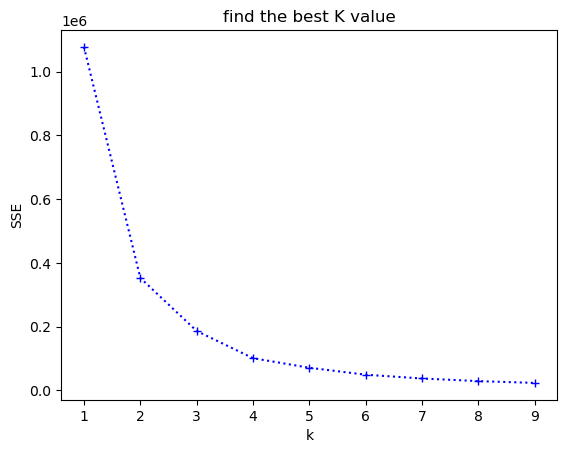

In [3]:
# 分析最佳K值
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = data.iloc[:,1: 3]

num = range(1,10) # 分别模拟k为1~9的情况

sse_result=[] # 用于存放每种k聚类后的SSE

for k in num:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(X)
    # inertia_表示样本到最近的聚类中心的距离总和。
    sse_result.append(kmeans.inertia_)

print(sse_result)

plt.plot(num,sse_result,'b+:') #'b*:'为线的格式设置，b表示蓝色，*为点的标记，:表示线型为点状线条。
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('find the best K value')
plt.show()

In [4]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# 输入数据
X = data.iloc[:, 1: 3]
k = 4

# 进行聚类
kmeans = KMeans(n_clusters=k, init='random')
labels = kmeans.fit_predict(X)
cents  = kmeans.cluster_centers_

# 画图
colors = ['r','g','b','c','m','y','#e24fff','#524C90','#845868']

print(cents)

# print([ [i, j] for i, j in zip(X.education_score, X.education_psychology_score)])

[[ 0.4527972  33.3513986 ]
 [ 0.36259284 64.47062795]
 [ 0.42562202 50.71869598]
 [ 0.29955947 78.38942731]]


### 相关性分析

In [5]:
df = data[['province', 'gender', 'education_score', 'education_psychology_score', 'work_address']]
df.head(3)

,province,gender,education_score,education_psychology_score,work_address
13727,石家庄市,0,48.000000,57.0,河北传媒学院
13728,保定市,0,50.643687,76.0,河北传媒学院
13729,秦皇岛市,1,19.000000,20.0,河北传媒学院


In [6]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据集
df = data[['province', 'gender', 'education_score', 'education_psychology_score', 'work_address']]

# 将分类变量转换为数值变量
df['province'] = df['province'].astype('category').cat.codes
df['work_address'] = df['work_address'].astype('category').cat.codes

# 划分特征和目标变量
X = df.drop(['education_score', 'education_psychology_score'], axis=1)
y1 = df['education_score']
y2 = df['education_psychology_score']

# 构建决策树分类模型1：预测科目1成绩
model3 = DecisionTreeClassifier()
model3.fit(X, pd.cut(y1, [0, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5]))

print("对科目1的影响")
print(model3.feature_importances_)


# 输出决策树
# plt.figure(figsize=(100, 60))
# plot_tree(model3)
# plt.savefig('Descitiontree.png')
# plt.show()

# 构建决策树分类模型2：预测科目2成绩
model4 = DecisionTreeClassifier()
model4.fit(X, pd.cut(y2, [0, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5]))
print("对科目2的影响")
print(model4.feature_importances_)

# # 输出决策树
# plt.figure(figsize=(10, 6))
# plot_tree(model4)
# plt.show()

对科目1的影响
[0.43762338 0.07178882 0.4905878 ]
对科目2的影响
[0.34382665 0.08276365 0.5734097 ]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_42084\142390259.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['province'] = df['province'].astype('category').cat.codes
C:\Users\Administrator\AppData\Local\Temp\ipykernel_42084\142390259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['work_address'] = df['work_address'].astype('category').cat.codes


In [7]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# 读取数据集
df = data[['province', 'gender', 'education_score', 'education_psychology_score', 'work_address']]
df = df.iloc[:500]
print(df.head(1))

# 将分类变量转换为数值变量
df['province'] = df['province'].astype('category').cat.codes
df['work_address'] = df['work_address'].astype('category').cat.codes

# 划分特征和目标变量
X = df.drop(['education_score', 'education_psychology_score'], axis=1)
y1 = df['education_score']
y2 = df['education_psychology_score']

# 构建决策树分类模型1：预测科目1成绩
model3 = DecisionTreeClassifier()
model3.fit(X, pd.cut(y1, [0, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5]))

print("对科目1的影响")
print(model3.feature_importances_)

# 构建决策树分类模型2：预测科目2成绩
model4 = DecisionTreeClassifier()
model4.fit(X, pd.cut(y2, [0, 60, 70, 80, 90, 100], labels=[1, 2, 3, 4, 5]))
print("对科目2的影响")
print(model4.feature_importances_)


      province  gender  education_score  education_psychology_score  \
13727     石家庄市       0             48.0                        57.0   

      work_address  
13727       河北传媒学院  
对科目1的影响
[0.56366368 0.0819502  0.35438612]
对科目2的影响
[0.4769415  0.09534988 0.42770862]
